In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

C:\Users\quaid\AppData\Local\Temp\ipykernel_27140\3601434573.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [6]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['station', 'measurement']


In [7]:
# Assign the measurement class to a variable called `Measurement` and
Measurement = Base.classes.measurement
# the station class to a variable called `Station`
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).scalar()
most_recent_date = dt.datetime.strptime(most_recent_date, "%Y-%m-%d")
print("Most Recent Date:", most_recent_date)

Most Recent Date: 2017-08-23 00:00:00


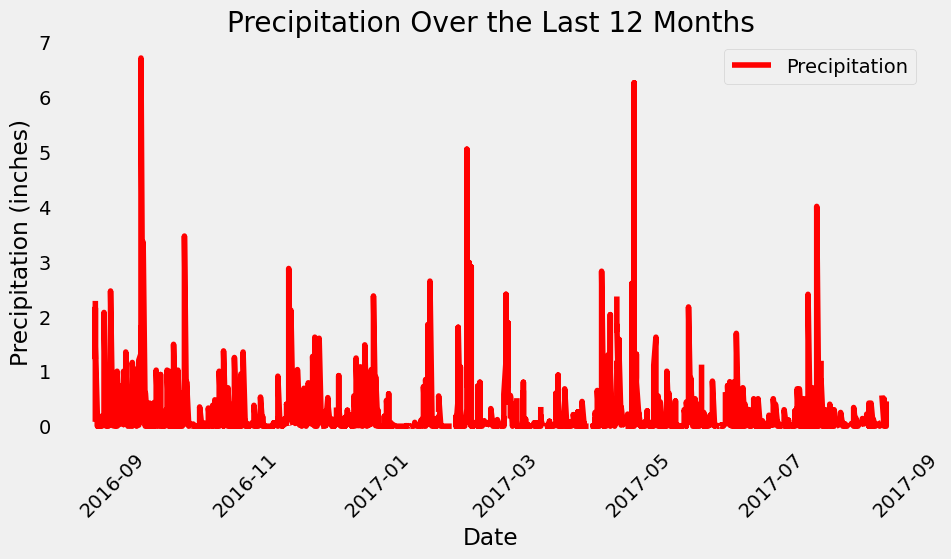

In [21]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)
precipitation_data = (
    session.query(Measurement.date, Measurement.prcp)
    .filter(Measurement.date >= one_year_ago)
    .order_by(Measurement.date)
    .all()
)
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])
precipitation_df["Date"] = pd.to_datetime(precipitation_df["Date"])
# Perform a query to retrieve the data and precipitation scores
precipitation_df.set_index("Date", inplace=True)
precipitation_df = precipitation_df.sort_index()
# Save the query results as a Pandas DataFrame. Explicitly set the column names


# Sort the dataframe by date


# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 5))
plt.plot(precipitation_df.index, precipitation_df["Precipitation"], label="Precipitation", color="red")
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Over the Last 12 Months")
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_stats = precipitation_df["Precipitation"].describe()
print(summary_stats)

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print("Total Number of Stations:", total_stations)

Total Number of Stations: 9


In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)
print("Most Active Stations (Station ID and Observation Count):")
for station, count in active_stations:
    print(station, count)

Most Active Stations (Station ID and Observation Count):
USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [16]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = active_stations[0][0]
temperature_stats = (
    session.query(
        func.min(Measurement.tobs),  # Minimum temperature
        func.max(Measurement.tobs),  # Maximum temperature
        func.avg(Measurement.tobs)   # Average temperature
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)
min_temp, max_temp, avg_temp = temperature_stats[0]
print(f"Station ID: {most_active_station_id}")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")

Station ID: USC00519281
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


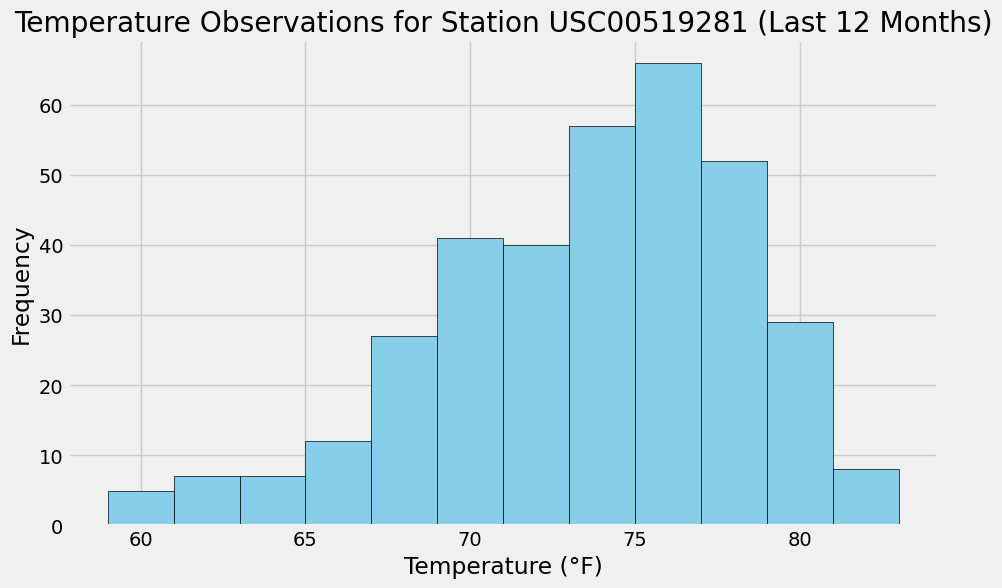

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)
    .all()
)
temperature_df = pd.DataFrame(temperature_data, columns=["Temperature"])
plt.figure(figsize=(10, 6))
plt.hist(temperature_df["Temperature"], bins=12, edgecolor="black", color="skyblue")
plt.title(f"Temperature Observations for Station {most_active_station_id} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

# Close Session

In [19]:
# Close Session
session.close()
